In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, dummy, metrics

print(pd.__version__) #1.1.3
print(np.__version__) #1.19.4
print(sns.__version__) #0.11.0
print(matplotlib.__version__) # 3.3.2
print(sklearn.__version__) # 0.23.2

1.1.3
1.19.4
0.11.0
3.3.2
0.23.2


# Récupération des données

In [2]:
data = pd.read_csv("data/train_df.csv")
data

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307502,307506,456251,0.0,0,0,1,0,157500.0,254700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,307503,307507,456252,0.0,1,0,0,0,72000.0,269550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,307504,307508,456253,0.0,1,0,0,0,153000.0,677664.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307505,307505,307509,456254,1.0,1,0,0,0,171000.0,370107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Isolation de la cible et séparation des données (train, test)

In [3]:
X = data.drop(columns=['TARGET','SK_ID_CURR','index', "Unnamed: 0"])
y = data["TARGET"]

del data
gc.collect()

20

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

del X, y
gc.collect()

X_train : (246005, 796)
X_test : (61502, 796)
y_train : (246005,)
y_test : (61502,)


20

# Etablissement d'une baseline

In [5]:
# dummy classifier 
dummy_classifier = dummy.DummyClassifier(strategy="stratified", random_state=123)
dummy_classifier.fit(X_train,y_train)

DummyClassifier(random_state=123, strategy='stratified')

In [6]:
# performances
y_pred = dummy_classifier.predict(X_test)
baseline = metrics.roc_auc_score(y_test, y_pred)
print(f"Baseline AUROC par dummy classifier  : {baseline}")

del dummy_classifier
gc.collect()

Baseline AUROC par dummy classifier  : 0.5008178332029487


40

# Entraînement d'un classifieur LightGBM sur le train set sur 5 folds (5 classifieurs)

In [7]:
# rectification des noms des features pour le classifieur LGBM

def replace_name(name):
    for c in ["[","]",",","{","}",'"',":"," "]:
        if c in name :
            name = name.replace(c,"_")
    return name
            
features = list(map(replace_name, X_train.columns))
X_train.columns = features
X_test.columns = features

In [8]:
# modèle de cross validation pour entraînement par fold
folds = model_selection.StratifiedKFold(n_splits= 5, shuffle=True, random_state=123)

# création des dataframes pour stocker les résultats
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # paramètres déterminés par optimisation Bayésienne
    clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.01604238736764179,
        num_leaves=35,
        colsample_bytree=0.5008424936188149,
        subsample=0.8715623,
        max_depth=7,
        reg_alpha=0.45530956234831316,
        reg_lambda=0.41291226155010513,
        min_split_gain=0.035332365150277316,
        min_child_weight=39.39942093978256,
        silent=-1,
        verbose=-1,
        random_state=123)
    
    # entraînement de chaque fold
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    # stockage des prédictions
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # stockage des features importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, metrics.roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.795773	training's binary_logloss: 0.237936	valid_1's auc: 0.777044	valid_1's binary_logloss: 0.243029
[400]	training's auc: 0.818561	training's binary_logloss: 0.227554	valid_1's auc: 0.786417	valid_1's binary_logloss: 0.238006
[600]	training's auc: 0.832722	training's binary_logloss: 0.221505	valid_1's auc: 0.790009	valid_1's binary_logloss: 0.236348
[800]	training's auc: 0.843888	training's binary_logloss: 0.216835	valid_1's auc: 0.79182	valid_1's binary_logloss: 0.235576
[1000]	training's auc: 0.853354	training's binary_logloss: 0.21283	valid_1's auc: 0.792652	valid_1's binary_logloss: 0.235246
[1200]	training's auc: 0.862134	training's binary_logloss: 0.209081	valid_1's auc: 0.793455	valid_1's binary_logloss: 0.234968
[1400]	training's auc: 0.870716	training's binary_logloss: 0.205308	valid_1's auc: 0.793896	valid_1's binary_logloss: 0.234785
[1600]	training's auc: 0.878438	training's binary_loglo

In [9]:
# affichage des performances

train_score = metrics.roc_auc_score(y_train, oof_preds)
test_score = metrics.roc_auc_score(y_test, sub_preds)
print(f"AUROC sur train set  : {train_score}")
print(f"AUROC sur test set : {test_score}")

AUROC sur train set  : 0.7894884703343306
AUROC sur test set : 0.7938340068307483


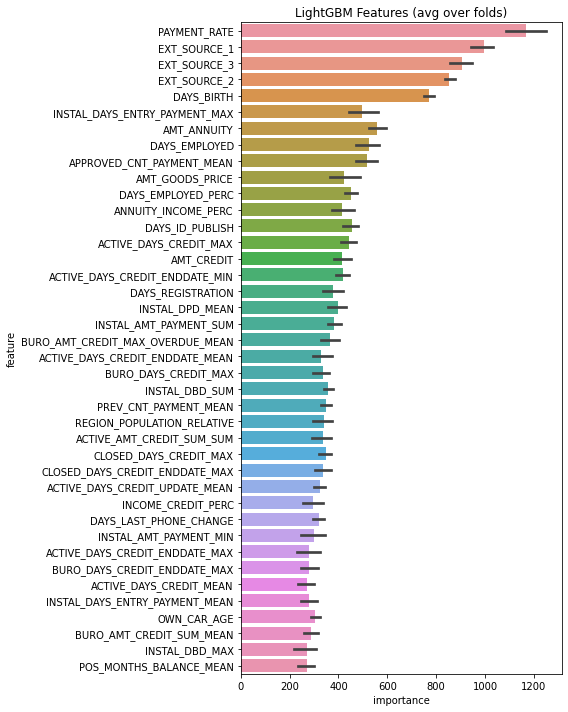

In [10]:
# affichage de l'importance des features

cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean()\
                    .sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('img/lgbm_importances01.png')

# Entraînement d'un LGBM Classifier unique sur le train set

In [11]:
# création d'un set de validation

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_train, y_train, test_size=0.2, 
                                                                      random_state=123)

In [12]:
# modèle avec les mêmes paramètres

clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.01604238736764179,
        num_leaves=35,
        colsample_bytree=0.5008424936188149,
        subsample=0.8715623,
        max_depth=7,
        reg_alpha=0.45530956234831316,
        reg_lambda=0.41291226155010513,
        min_split_gain=0.035332365150277316,
        min_child_weight=39.39942093978256,
        silent=-1,
        verbose=-1,
        random_state=123)

# entraînement
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.797684	training's binary_logloss: 0.236584	valid_1's auc: 0.768502	valid_1's binary_logloss: 0.247619
[400]	training's auc: 0.81982	training's binary_logloss: 0.226244	valid_1's auc: 0.778405	valid_1's binary_logloss: 0.243087
[600]	training's auc: 0.834086	training's binary_logloss: 0.220087	valid_1's auc: 0.78232	valid_1's binary_logloss: 0.241573
[800]	training's auc: 0.845255	training's binary_logloss: 0.21534	valid_1's auc: 0.784219	valid_1's binary_logloss: 0.240885
[1000]	training's auc: 0.854765	training's binary_logloss: 0.211231	valid_1's auc: 0.785301	valid_1's binary_logloss: 0.240541
[1200]	training's auc: 0.863378	training's binary_logloss: 0.20747	valid_1's auc: 0.785989	valid_1's binary_logloss: 0.240328
[1400]	training's auc: 0.870942	training's binary_logloss: 0.204058	valid_1's auc: 0.786652	valid_1's binary_logloss: 0.240157
[1600]	training's auc: 0.87844	training's binary_logloss:

LGBMClassifier(colsample_bytree=0.5008424936188149,
               learning_rate=0.01604238736764179, max_depth=7,
               min_child_weight=39.39942093978256,
               min_split_gain=0.035332365150277316, n_estimators=10000,
               num_leaves=35, random_state=123, reg_alpha=0.45530956234831316,
               reg_lambda=0.41291226155010513, silent=-1, subsample=0.8715623,
               verbose=-1)

In [13]:
# performances

y_pred = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
metrics.roc_auc_score(y_test, y_pred)

0.7908508887626532

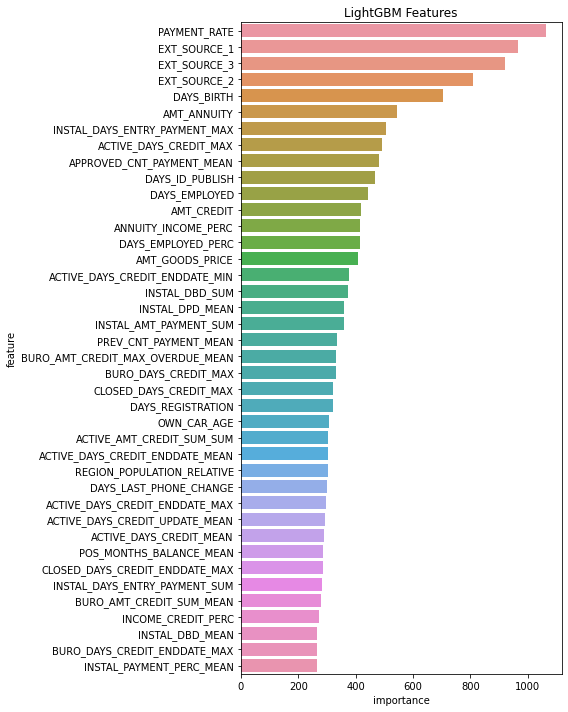

In [14]:
# features importances

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = clf.feature_importances_
best_features_idx = feature_importance_df.sort_values(by="importance", ascending=False)[:40].index
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[best_features_idx].sort_values(by="importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()

Les performances sont à peine moins bonnes, je garde donc ce principe d'un classifieur unique.
